# Mixture Models


In the previous notebook (notebook nr. 3 in this repo) the mixture model was implemented in the model itself. Though this is great for understanding what is going on, it isn't very efficient when sampling the model. Furthermore, individuals were assigned to groups using only one of the samples, since we sample the model thousands of times it is better to take all of those into account. 

Furthermore, when assigning a species to new observations, you don't want to re-run the entire sampling step. Ideally you can fit the model on some initial data and then predict the group using new, previously unseen, data. With the code in the previous post this was not possible.

So while we had a great model, here are a few trick that can still be used to further improve upon it. This notebook is based on the code discussed [here](https://discourse.pymc.io/t/properly-sampling-mixture-models/986/7) and [here](https://discourse.pymc.io/t/get-probability-of-parameter-given-new-data/2511/2).


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt

import altair as alt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
penguin_df = (
    pd.read_csv("./data/penguins_size.csv").drop(columns=["island", "sex"]).dropna()
)
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


<IPython.core.display.Javascript object>

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_penguin_df = scaler.fit_transform(penguin_df.drop(columns=["species"]))
scaled_penguin_df = pd.DataFrame(scaled_penguin_df, columns=penguin_df.columns[1:])
scaled_penguin_df["species"] = list(penguin_df["species"])
scaled_penguin_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,-0.884499,0.785449,-1.418347,-0.564142,Adelie
1,-0.811126,0.126188,-1.062250,-0.501703,Adelie
2,-0.664380,0.430462,-0.421277,-1.188532,Adelie
3,-1.324737,1.089724,-0.563715,-0.938776,Adelie
4,-0.847812,1.748985,-0.777373,-0.689020,Adelie
...,...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175,Gentoo
338,0.527932,-1.445897,1.003109,0.809516,Gentoo
339,1.188289,-0.735923,1.501644,1.933419,Gentoo
340,0.234440,-1.192335,0.789451,1.246590,Gentoo


<IPython.core.display.Javascript object>

In [4]:
scaled_penguin_df.groupby(["species"]).agg(
    mean_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="mean"),
    std_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="std"),
    mean_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="mean"),
    std_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="std"),
    mean_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="mean"),
    std_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="std"),
    mean_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="mean"),
    std_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="std"),
)

,mean_culmen_length,std_culmen_length,mean_culmen_depth,std_culmen_depth,mean_flipper_length,std_flipper_length,mean_body_mass,std_body_mass
species,,,,,,,,
Adelie,-0.941108,0.488555,0.606109,0.616992,-0.780675,0.465735,-0.625754,0.572648
Chinstrap,0.901001,0.612528,0.643753,0.575786,-0.362625,0.507928,-0.585261,0.479950
Gentoo,0.657229,0.565313,-1.099980,0.497600,1.158865,0.461855,1.091761,0.629531


<IPython.core.display.Javascript object>

Here the ```pm.Mixture``` is used to determine the optimal values for the different Multivariate Normals that need to be fit on the data. Another difference here is that each MvNormal gets its own covariance matrix, instead of using a single one for each distribution.

**Note:** there is a bug on Windows and the sampling doesn't work when started on multiple cores. To avoid this the inference step is limited to one chain and one core. 

In [5]:
n_clusters = 3
data = scaled_penguin_df.drop(columns=["species"]).values
n_observations, n_features = data.shape
with pm.Model() as Model:
    # Create a covariance matrix for each potential cluster which relates all features of our data
    lower = tt.stack(
        [
            pm.LKJCholeskyCov(
                "sigma_{}".format(k),
                n=n_features,
                eta=2.0,
                sd_dist=pm.HalfNormal.dist(sd=1.0),
            )
            for k in range(n_clusters)
        ]
    )
    chol = tt.stack(
        [pm.expand_packed_triangular(n_features, lower[k]) for k in range(n_clusters)]
    )

    # The center of each cluster
    mus = tt.stack(
        [
            pm.Normal("mu_{}".format(k), 0.0, 1.5, shape=n_features)
            for k in range(n_clusters)
        ]
    )

    # Create the multivariate normal distribution for each cluster
    MultivariateNormals = [
        pm.MvNormal.dist(mus[k], chol=chol[k], shape=n_features)
        for k in range(n_clusters)
    ]

    # Create the weights for each cluster which measures how much impact they have
    w = pm.Dirichlet("w", np.ones(n_clusters) / n_clusters)

    obs = pm.Mixture("obs", w=w, comp_dists=MultivariateNormals, observed=data)
    trace = pm.sample(2000, cores=1, tune=2000, chains=1)

<ipython-input-5-5402eac7bc69>:39: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, cores=1, tune=2000, chains=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w, mu_2, mu_1, mu_0, sigma_2, sigma_1, sigma_0]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 75 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


<IPython.core.display.Javascript object>

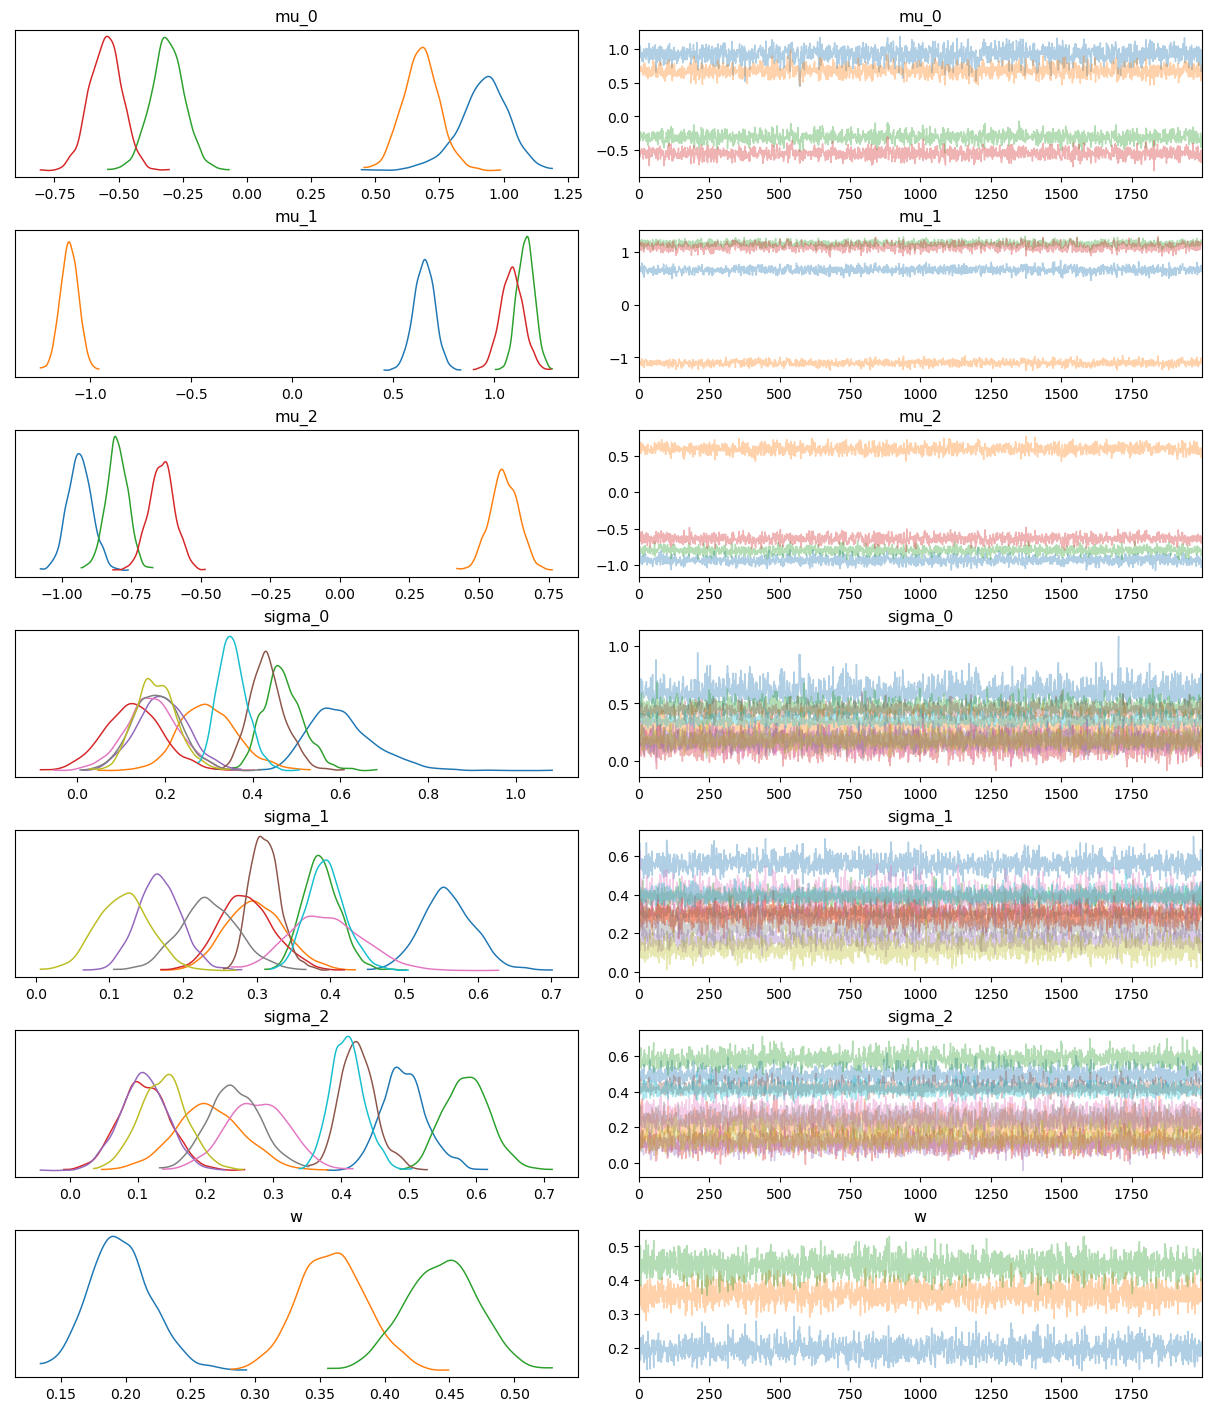

<IPython.core.display.Javascript object>

In [6]:
with Model:
    pm.plot_trace(trace)
plt.show()

Now the mixture model was fitted on the dataset, though there is one issue. It is far less obvious how to get get cluster assignments for this model. The previous model explicitly assigned a category to each observation, that is not the case here. We'll have to check with each of the final distributions in the model which fits best (for each sample) and based on that deside wich group we assign to each observation. Note that here also new data can be passed in that was not used for sampling, so in one go that point is tackled too.

In [7]:
def prob_weights(model_mixed, trace_mixed, ynew):
    complogp = obs.distribution._comp_logp(theano.shared(ynew))
    f_complogp = model_mixed.model.fastfn(complogp)
    weight_ynew = []
    ichain = 0  # just use the first chain, as groups can differ between chains you can't mix them

    for point_idx in range(len(trace_mixed)):
        point = trace_mixed._straces[ichain].point(point_idx)
        point = {
            k: v
            for k, v in point.items()
            if k.startswith("mu_") or "cholesky" in k or "w_stick" in k
        }  # We need to remove a number of un-necessary keys.
        prob = np.exp(f_complogp(point))
        prob /= prob.sum()
        weight_ynew.append(prob)

    weight_ynew = np.asarray(weight_ynew).squeeze()

    return weight_ynew.mean(axis=0)


with Model:
    weights = prob_weights(Model, trace, data)

<IPython.core.display.Javascript object>

(342, 3)

<IPython.core.display.Javascript object>

In [8]:
weights_df = pd.DataFrame(
    weights, columns=[f"Group {d+1}" for d in range(weights.shape[1])]
)
weights_df["Predicted Group"] = weights_df.apply(lambda x: x.idxmax(), axis=1)

weights_df

,Group 1,Group 2,Group 3,Predicted Group
0,8.382822e-07,3.585496e-27,2.134100e-03,Group 3
1,2.719038e-05,8.994132e-19,3.469642e-03,Group 3
2,9.999582e-05,1.876578e-19,1.003150e-03,Group 3
3,3.711145e-07,2.739789e-26,1.710354e-03,Group 3
4,7.053319e-08,1.083051e-32,5.662282e-04,Group 3
...,...,...,...,...
337,1.704825e-13,3.702778e-03,6.052112e-15,Group 2
338,4.878579e-12,1.184303e-02,1.632105e-13,Group 2
339,1.321670e-14,5.686282e-03,5.483161e-16,Group 2
340,6.149976e-12,4.603352e-03,9.009127e-13,Group 2


<IPython.core.display.Javascript object>

Finally, we'll visually inspect the model. As we are now averaging the results based on thousands of samples, there is a wisdom of the crowd effect. As some samples might get the species somewhat wrong, by combining them their joint prediction outperforms most individual ones.

In [9]:
penguin_df["group"] = weights_df["Predicted Group"].tolist()
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,group
0,Adelie,39.1,18.7,181.0,3750.0,Group 3
1,Adelie,39.5,17.4,186.0,3800.0,Group 3
2,Adelie,40.3,18.0,195.0,3250.0,Group 3
4,Adelie,36.7,19.3,193.0,3450.0,Group 3
5,Adelie,39.3,20.6,190.0,3650.0,Group 3
...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,Group 2
340,Gentoo,46.8,14.3,215.0,4850.0,Group 2
341,Gentoo,50.4,15.7,222.0,5750.0,Group 2
342,Gentoo,45.2,14.8,212.0,5200.0,Group 2


<IPython.core.display.Javascript object>

In [10]:
plot_df = (
    penguin_df.groupby(["species", "group"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)
plot_df

,species,group,count
0,Adelie,Group 1,2
1,Adelie,Group 3,149
2,Chinstrap,Group 1,66
3,Chinstrap,Group 3,2
4,Gentoo,Group 2,123


<IPython.core.display.Javascript object>

In [11]:
alt.Chart(plot_df).mark_bar().encode(
    x=alt.X("group", title=None),
    y=alt.Y("count", title="Count"),
    color=alt.Color("species", title="Species"),
    tooltip=["group", "count", "species"],
).properties(width=400)

alt.Chart(...)

<IPython.core.display.Javascript object>